In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output

from utils import dfwellgr,marker_ssig,extract_signature_Xy,recall_tops, find_optimal_tolerance
from utils import window, plot_pred_distribution

torch.manual_seed(42)
np.random.seed(42)


### LOAD Traing and Testing Data

In [2]:
#Load Prepared Training Data

X = np.load('prepared_data/X_201.npy')
y= np.load('prepared_data/y_201.npy')

# X = np.load('prepared_data/X_101.npy')
# y= np.load('prepared_data/y_101.npy')

# X = np.load('prepared_data/X_51.npy')
# y= np.load('prepared_data/y_51.npy')


In [3]:
#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

In [4]:
df_tops = pd.read_parquet('Training/tops.parquet', engine='fastparquet')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops[df_tops['CONRAD'] - df_tops['SYLVAIN'] < 0] #Here we can see incorrect data

well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)
df_tops = df_tops[df_tops.index.isin(well_array[0][0])]

### Create DataLoader

In [5]:
#one hot for y 
y = np.eye(np.max(y) + 1)[y]

#nomralization for X
eps = 1e-6
f_mean = X.mean(axis=0)
f_std = X.std(axis=0) + eps  
X_norm= (X - f_mean) / f_std

#Split train & validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#Create dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32) 
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)  

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False)  

dataset_test = TensorDataset(X_valid_tensor, y_valid_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False) 

### Training FUNCTION

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, validation_loss):
        improvement = self.min_loss - validation_loss
        if improvement > self.min_delta:
            self.min_loss = validation_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [43]:
def train(num_epochs,model,patience=2):
   
    start = time.time()
       
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopper(patience,min_delta= 1e-4)

    for epoch in range(num_epochs):

        #========================TRAIN===========================#
        model.train()
        for i, (input_tensor, target_tensor) in enumerate(dataloader_train):
            input_tensor = input_tensor
            target_tensor = target_tensor.float()
            optimizer.zero_grad()

            output = model(input_tensor) 
            train_loss = criterion(output, target_tensor)

            train_loss.backward()
            
            optimizer.step()

        #========================EVALUATE===========================#
        num_correct = 0
        num_samples = 0
        model.eval()

        with torch.no_grad():
            for i, (input_tensor, target_tensor) in enumerate(dataloader_test):
                
                input_tensor = input_tensor
                target_tensor = target_tensor.float()
                output = model(input_tensor) 
  
                validation_loss = criterion(output, target_tensor)

                target_classes = target_tensor.long()
                target_classes = torch.argmax(target_classes, dim=1)
      
                pred_classes = torch.argmax(output, dim=1)

                num_correct += torch.sum(pred_classes == target_classes).item()
                current_batch_size = input_tensor.size(0) 
                num_samples += current_batch_size
            
            accuracy = num_correct / num_samples

            print(f'Epoch {epoch+1}/{num_epochs},   Training Loss:{train_loss.item():.5f},   Accuracy: {accuracy * 100:.2f}%,    Validation Loss: {validation_loss.item():.5f}')
            if epoch+1 > 5:
                if early_stopper.early_stop(validation_loss):  
                    print("Early Stop Triggered")           
                    break

    ext = time.time() - start
    print('Total training time',ext)
    return model

### THREE S2S Model

In [8]:
#import model
from s2s_model.BiGRUA import BiGRUAttn
from s2s_model.LSTMA import LSTMAttn
from s2s_model.ML_model import Attention,Encoder,Decoder,Seq2Seq
#impor testing func
from utlis_s2s import get_markers_rocket_order
from constraints import get_markers_rocket_order_with_constraint

#### BIGUA MODEL

In [10]:
input_size = X.shape[2]
hidden_size = 256
model = BiGRUAttn(input_size,hidden_size)
model=train(100,model)


Epoch 1/100,   Training Loss:0.75891,   Accuracy: 98.22%,    Validation Loss: 0.75248
Epoch 2/100,   Training Loss:0.74910,   Accuracy: 99.17%,    Validation Loss: 0.75845
Epoch 3/100,   Training Loss:0.74716,   Accuracy: 99.05%,    Validation Loss: 0.77521
Epoch 4/100,   Training Loss:0.74612,   Accuracy: 99.41%,    Validation Loss: 0.76994
Epoch 5/100,   Training Loss:0.74539,   Accuracy: 99.41%,    Validation Loss: 0.77282
Epoch 6/100,   Training Loss:0.74498,   Accuracy: 99.52%,    Validation Loss: 0.76960
Epoch 7/100,   Training Loss:0.74524,   Accuracy: 99.41%,    Validation Loss: 0.74563
Epoch 8/100,   Training Loss:0.74465,   Accuracy: 99.64%,    Validation Loss: 0.74588
Epoch 9/100,   Training Loss:0.74445,   Accuracy: 99.64%,    Validation Loss: 0.74479
Epoch 10/100,   Training Loss:0.74431,   Accuracy: 99.64%,    Validation Loss: 0.74456
Epoch 11/100,   Training Loss:0.74422,   Accuracy: 99.64%,    Validation Loss: 0.74432
Epoch 12/100,   Training Loss:0.74416,   Accuracy: 9

In [10]:
# torch.save(model, 'saved_model/bigu_model.pth')
# torch.save(model.state_dict(), 'saved_model/bigu_model_state.pth')

# Load the model
model = torch.load('saved_model/bigu_model.pth')
model.load_state_dict(torch.load('saved_model/bigu_model_state.pth'))

<All keys matched successfully>

#### Testing

In [12]:
#Predict ALL WITHOUT CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 29.67664384841919


In [13]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 3.79
tolerance 15, recall 0.9866666666666667, mae 3.79
tolerance 10, recall 0.96, mae 3.79
tolerance 5, recall 0.8133333333333334, mae 3.79
Largest Error MARCEL: 23.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 84.0
Optimal Tolerance : 84


In [14]:
#Predict ALL WITHOUT CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraint(f_mean, f_std,df_tops, df_test_log, well, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             alpha=0.5, 
                                             confidence_level=0.96)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 26.539350986480713


In [15]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 3.701733333333347
tolerance 15, recall 0.98, mae 3.701733333333347
tolerance 10, recall 0.94, mae 3.701733333333347
tolerance 5, recall 0.7866666666666666, mae 3.701733333333347
Largest Error MARCEL: 23.0
Largest Error SYLVAIN: 28.840000000000146
Largest Error CONRAD: 12.0
Optimal Tolerance : 29


#### LSTM Model 

In [65]:
input_size = X.shape[2]
hidden_size = 128
output_dim = 100
model = LSTMAttn(input_size,hidden_size,output_dim)
model=train(100,model)

Epoch 1/100,   Training Loss:0.99967,   Accuracy: 96.08%,    Validation Loss: 1.31952
Epoch 2/100,   Training Loss:0.82705,   Accuracy: 97.15%,    Validation Loss: 0.76173
Epoch 3/100,   Training Loss:0.78558,   Accuracy: 98.34%,    Validation Loss: 0.75020
Epoch 4/100,   Training Loss:0.76309,   Accuracy: 99.05%,    Validation Loss: 0.75104
Epoch 5/100,   Training Loss:0.75660,   Accuracy: 99.17%,    Validation Loss: 0.74757
Epoch 6/100,   Training Loss:0.75199,   Accuracy: 99.29%,    Validation Loss: 0.74696
Epoch 7/100,   Training Loss:0.75033,   Accuracy: 99.29%,    Validation Loss: 0.74583
Epoch 8/100,   Training Loss:0.74907,   Accuracy: 99.29%,    Validation Loss: 0.74501
Epoch 9/100,   Training Loss:0.74767,   Accuracy: 99.41%,    Validation Loss: 0.74467
Epoch 10/100,   Training Loss:0.74687,   Accuracy: 99.41%,    Validation Loss: 0.74445
Epoch 11/100,   Training Loss:0.74711,   Accuracy: 99.41%,    Validation Loss: 0.74428
Epoch 12/100,   Training Loss:0.74636,   Accuracy: 9

In [66]:
torch.save(model, 'saved_model/lstm_model.pth')
torch.save(model.state_dict(), 'saved_model/lstm_model_state.pth')

## Load the model
# model = torch.load('saved_model/lstm_model.pth'')
# model.load_state_dict(torch.load('saved_model/lstm_model_state.pth'))

#### Testing

In [67]:
#Predict ALL WITHOUT CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 16.605879068374634


In [68]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.98, mae 3.96
tolerance 15, recall 0.98, mae 3.96
tolerance 10, recall 0.9533333333333334, mae 3.96
tolerance 5, recall 0.7866666666666666, mae 3.96
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 11.0
Largest Error CONRAD: 86.0
Optimal Tolerance : 86


In [69]:
#Predict ALL WITH CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraint(f_mean, f_std,df_tops, df_test_log, well, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             alpha=0.5, 
                                             confidence_level=0.96)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 17.276864767074585


In [70]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 3.565600000000013
tolerance 15, recall 0.9866666666666667, mae 3.565600000000013
tolerance 10, recall 0.9533333333333334, mae 3.565600000000013
tolerance 5, recall 0.78, mae 3.565600000000013
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 28.840000000000146
Largest Error CONRAD: 13.700000000000728
Optimal Tolerance : 29


#### ML Model

In [58]:
input_size = X.shape[2]
hidden_size = 128
num_layers = 2
output_size = 100
conv_output_dim = 64
dense_output_dim = 128
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Instantiate model
attention = Attention(hidden_size)
encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(output_size, hidden_size, num_layers, attention)
model = Seq2Seq(encoder, decoder, conv_output_dim, dense_output_dim, num_classes,device).to(device)

In [59]:
model = train(100,model,patience=0)

Epoch 1/100,   Training Loss:1.15180,   Accuracy: 51.43%,    Validation Loss: 1.28913
Epoch 2/100,   Training Loss:0.99481,   Accuracy: 68.29%,    Validation Loss: 1.04987
Epoch 3/100,   Training Loss:0.89939,   Accuracy: 85.04%,    Validation Loss: 0.87446
Epoch 4/100,   Training Loss:0.77870,   Accuracy: 99.05%,    Validation Loss: 0.77588
Epoch 5/100,   Training Loss:0.75152,   Accuracy: 98.81%,    Validation Loss: 0.75713
Epoch 6/100,   Training Loss:0.74759,   Accuracy: 99.17%,    Validation Loss: 0.74803
Epoch 7/100,   Training Loss:0.74599,   Accuracy: 99.17%,    Validation Loss: 0.74638
Epoch 8/100,   Training Loss:0.74525,   Accuracy: 99.29%,    Validation Loss: 0.74552
Epoch 9/100,   Training Loss:0.74484,   Accuracy: 99.41%,    Validation Loss: 0.74503
Epoch 10/100,   Training Loss:0.74457,   Accuracy: 99.41%,    Validation Loss: 0.74472
Epoch 11/100,   Training Loss:0.74439,   Accuracy: 99.41%,    Validation Loss: 0.74451
Epoch 12/100,   Training Loss:0.74426,   Accuracy: 9

In [60]:
torch.save(model, 'saved_model/convgrua_model.pth')
torch.save(model.state_dict(), 'saved_model/convgrua_model_model_state.pth')

## Load the model
# model = torch.load('saved_model/convgrua_model.pth')
# model.load_state_dict(torch.load('saved_model/convgrua_model_model_state.pth'))

In [61]:
#Predict ALL WITHOUT CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 72.72741603851318


In [62]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 3.6933333333333334
tolerance 15, recall 0.98, mae 3.6933333333333334
tolerance 10, recall 0.92, mae 3.6933333333333334
tolerance 5, recall 0.8066666666666666, mae 3.6933333333333334
Largest Error MARCEL: 33.0
Largest Error SYLVAIN: 18.0
Largest Error CONRAD: 12.0
Optimal Tolerance : 33


In [63]:
#Predict ALL WITH CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraint(f_mean, f_std,df_tops, df_test_log, well, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             alpha=0.5, 
                                             confidence_level=0.96)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 73.18808388710022


In [64]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.98, mae 3.9622666666666797
tolerance 15, recall 0.9733333333333334, mae 3.9622666666666797
tolerance 10, recall 0.9133333333333333, mae 3.9622666666666797
tolerance 5, recall 0.78, mae 3.9622666666666797
Largest Error MARCEL: 33.0
Largest Error SYLVAIN: 32.340000000000146
Largest Error CONRAD: 13.200000000000728
Optimal Tolerance : 33


Prediction:[6452.0, 6594.0, 7019.299999999999]
Real:[6460.0, 6592.0, 6620.0]


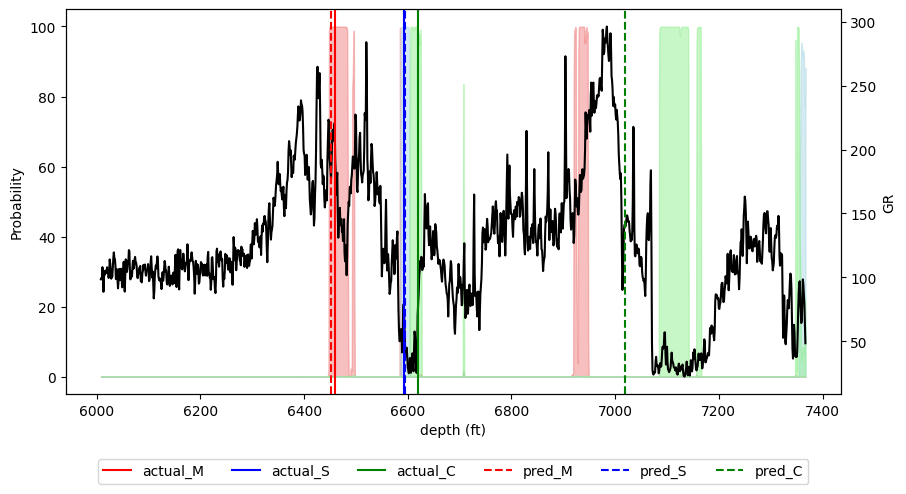

In [42]:
# Example Testing with one well before start process prediciton on the entire testing dataset

df_tops = df_tops[df_tops.index.isin(well_array[0][0])]

wsize = 201 #adjust as needed
well = 512322535
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order_with_constraint(f_mean, f_std,df_tops, df_test_log, well, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             alpha=0.5, 
                                             confidence_level=0.96)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)